In [311]:
using PropBiology

using ForwardDiff
using LinearAlgebra

using Plots

using Printf

In [312]:
softmax(args::Real...; α::Real = 20.0) = log(sum(exp.(args .* α))) ./ α

softmax (generic function with 1 method)

In [313]:
# Airfoil properties: NACA-2412

CL0 = 0.35
Cm0 = 0.06

CLα = 5.32

CLmax = 1.5

polar = [
    0.008,
    -0.005,
    0.011
]

3-element Vector{Float64}:
  0.008
 -0.005
  0.011

In [314]:
# Engine and battery data

#  600 KV motor, 6S
# Turnigy 5000mAh 4S 40C Lipo Pack with XT90

Kv = 600.0
Ri = 0.22
I0 = 2.6
Imax = 55.0

Ke = 60.0 / ((2 * π) * Kv)

V = 3.7 * 6
C = 20.0 * 3

60.0

In [315]:
function fobj(x::AbstractVector; V∞::Real = 25.0, Tmin::Real = 20.0, croot_min::Real = 3e-2)

    D, croot, λ, pitch, t, ω = x

    R = D / 2

    E = Ke * ω

    res = PropBiology.simulation(
        [0.0, R], [croot, croot * λ], ω;
        polar = polar,
        CLα = CLα,
        CL0 = CL0, 
        Cm0 = Cm0,
        γ = [pitch, pitch + t],
        V∞ = V∞
    )

    I = res.Q * ω / E

    g = max(
        softmax(
            - (V - E - Ri * I0) / V,
            (Tmin - res.T) / Tmin,
            (maximum(res.CL) - CLmax) / CLmax,
            (croot_min - croot) / croot_min,
            (λ - 1.0),
            - λ
        ) - 5e-2,
        0.0
    )

    f = I

    [f, g]

end

fg_grads(x::AbstractVector; kwargs...) = let J = ForwardDiff.jacobian(
    x -> fobj(x; kwargs...), x
)

    ∇f = J[1, :]
    ∇g = J[2, :]

    ∇f, ∇g

end

fg_grads (generic function with 1 method)

In [316]:
x = [ #[0.4, 0.03, 0.33, deg2rad(30.0), deg2rad(- 25.0), 10000.0 * (2 * π) / 60.0]
    0.395431803454289
    0.031222959569856018
    0.3293526217759031
    0.5218400478648935
    -0.4374880833021367
    10000.0 * (2 * π) / 60.0 # 1047.1975513652812
]

6-element Vector{Float64}:
    0.395431803454289
    0.031222959569856018
    0.3293526217759031
    0.5218400478648935
   -0.4374880833021367
 1047.1975511965977

In [317]:
# gradient descent

α = 8e-5

fhist = []
ghist = []
xhist = []

for i = 1:200
    f, g = fobj(x)
    ∇f, ∇g = fg_grads(x)

    push!(xhist, copy(x))
    push!(fhist, f)
    push!(ghist, g)

    p = - α * ∇f

    x .+= p
    g += p ⋅ ∇g

    x .-= g .* ∇g ./ (norm(∇g) ^ 2 + 1e-10)
end

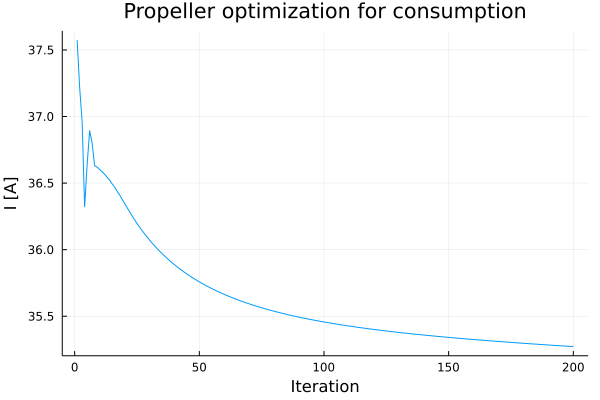

In [318]:
plot(fhist, xlabel = "Iteration", ylabel = "I [A]", title = "Propeller optimization for consumption", legend = false)

In [319]:
x = xhist[end]

D, croot, λ, pitch, t, ω = x

R = D / 2

current_prop = (uinf, om = ω) -> PropBiology.simulation(
    [0.0, R], [croot, croot * λ], om;
    polar = polar,
    CLα = CLα,
    CL0 = CL0, 
    Cm0 = Cm0,
    γ = [pitch, pitch + t],
    V∞ = uinf
)

#218 (generic function with 2 methods)

In [320]:
vs = collect(0.0:3.0:45.0)

results = current_prop.(vs)

Is = [
    res.Q / Ke for res in results
]
Tmaxs = [
    res.T for res in results
]

16-element Vector{Float64}:
 40.53534704732973
 38.5164217488677
 36.32498816518226
 33.96416674112497
 31.44235760179891
 28.77295243163406
 25.973406517442584
 23.063817608038313
 20.065279650700507
 16.998310475296343
 13.881590748552947
 10.73113644470491
  7.559910751075758
  4.377800139468718
  1.1918437422471768
 -1.9933937835446114

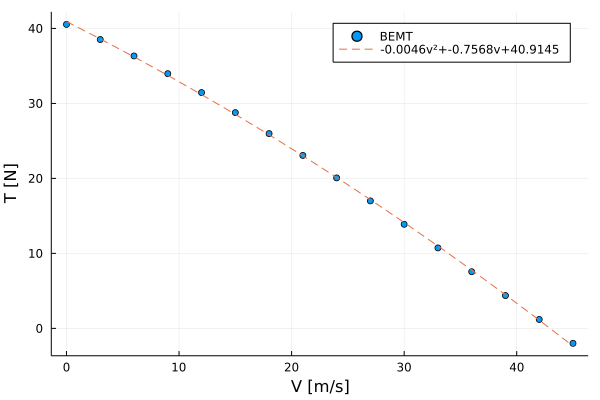

In [321]:
coefs = let A = [vs .^ 2 vs ones(size(vs)...)]
    (A' * A) \ (A' * Tmaxs)
end

lab = @sprintf "%.4fv²+%.4fv+%.4f" coefs[1] coefs[2] coefs[3]

p = scatter(vs, Tmaxs, xlabel = "V [m/s]", ylabel = "T [N]", legend = :topright, label = "BEMT")
plot!(p, vs, coefs[1] .* vs .^ 2 .+ coefs[2] .* vs .+ coefs[3], legend = :topright, label = lab, linestyle = :dash)

p

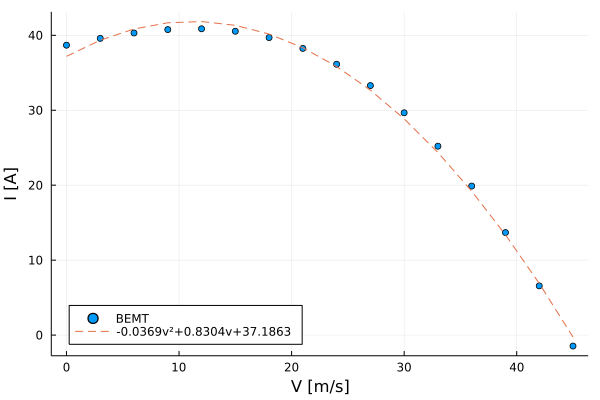

In [322]:
coefs = let A = [vs .^ 2 vs ones(size(vs)...)]
    (A' * A) \ (A' * Is)
end

lab = @sprintf "%.4fv²+%.4fv+%.4f" coefs[1] coefs[2] coefs[3]

p = scatter(vs, Is, xlabel = "V [m/s]", ylabel = "I [A]", legend = :topright, label = "BEMT")
plot!(p, vs, coefs[1] .* vs .^ 2 .+ coefs[2] .* vs .+ coefs[3], legend = :bottomleft, label = lab, linestyle = :dash)

p